In [ ]:
"""
If you'd like a tidy version of this Notebook without all the code cells,
you can view the `data_vis.html` file.
"""

# Exploratory Data Analysis

In this file, we will be trying to gain insights from a cleaned dataset of an online retailer, answering common questions management/exec might ask.

The code to generate the plots in this notebook is very much specific to this dataset, and has low reusability, aside from use as boiler-plate.

# Perform Cleaning

The thought process for the cleaning decisions is outlined in `dataplay.ipynb`.

In [2]:
import pandas as pd
from db_utils import DataTransform
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Enables Plotly rendering in html

"""
To re-export to html, run:
jupyter nbconvert --to html --TagRemovePreprocessor.remove_input_tags="{'hide-input'}" data_vis.ipynb
"""

%reload_ext autoreload
%autoreload 2

df = pd.read_csv('cust_act1.csv')
dtype_change = {
    "visitor_type": "category",
    "traffic_type": "category",
    "region": "category",
    "browser": "category",
    "operating_systems": "category",
    "administrative": "Int32",
    "informational": "Int32",
    "product_related": "Int32"
}
# Perform special transform case for months to be an ordered category
months_ordered = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['month'] = pd.Categorical(df['month'], categories=months_ordered, ordered=True)
# Perform the transform from dict
df = DataTransform(df).changetype(dtype_change)

# Impute & drop rows
from db_utils import DataFrameTransform as dft

cols_to_impute_na = [
    "product_related_duration",
    "informational_duration",
    "administrative_duration"
]
cols_to_drop_na = [
    "operating_systems",
]
cols_to_mode_na = [
    "administrative",
    "product_related"
]

dft(df, cols_to_drop_na).drop_missing()
dft(df, cols_to_impute_na).impute_missing()
dft(df, cols_to_mode_na).impute_missing(strategy="mode")

# Copy DF with outliers removed

cols_with_outliers = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration",
    "page_values"
]
df_sans_outliers = dft(df, columns=cols_with_outliers).drop_outliers(z_threshold=4.5)

# Manually drop overly correlated column
if "exit_rates" in df_sans_outliers.columns:
    df_sans_outliers = df_sans_outliers.drop(columns="exit_rates")

Dropped 11 rows with missing values in ['operating_systems'].
Imputed missing values in 'product_related_duration' with median (586.00, skew=3.64).
Imputed missing values in 'informational_duration' with median (0.00, skew=7.21).
Imputed missing values in 'administrative_duration' with median (6.00, skew=4.67).
Imputed missing values in 'administrative' with mode (0, skew=2.00).
Imputed missing values in 'product_related' with mode (1, skew=3.37).


In [3]:
dfcl = df_sans_outliers

# T1. What are our customers doing?

#### <a id='T1-1'></a> 1. Are sales proportionally happening more on weekends?
>a: Yes, ever so slightly. 15.8% of visits end in revenue on weekends and 14.3% on weekdays.

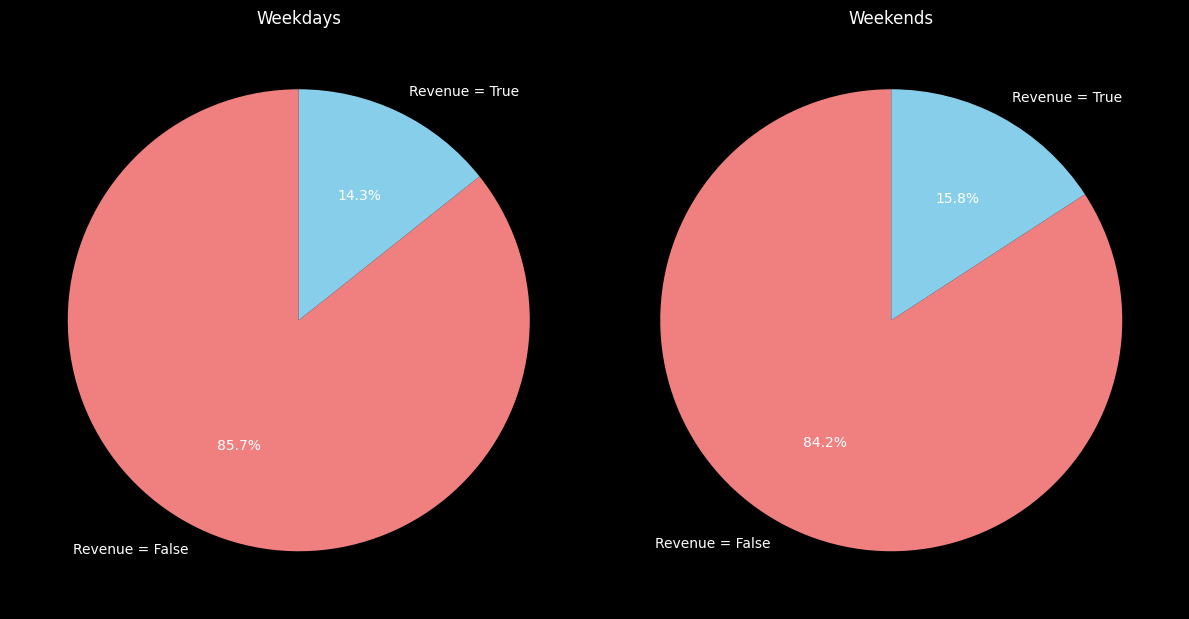

In [4]:
import matplotlib.pyplot as plt


counts = dfcl.groupby(["weekend", "revenue"]).size().unstack(fill_value=0)
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

weekday_counts = counts.loc[False]
axes[0].pie(
    weekday_counts, labels=["Revenue = False", "Revenue = True"], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue']
)
axes[0].set_title("Weekdays")

weekend_counts = counts.loc[True]
axes[1].pie(
    weekend_counts, labels=["Revenue = False", "Revenue = True"], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue']
)
axes[1].set_title("Weekends")

plt.tight_layout()
plt.show()

#### 2. Which regions are generating the most revenue currently?
>a: North America

In [5]:
import plotly.express as px

fig = px.histogram(
    dfcl,
    x="region",
    y="page_values",
    histfunc="sum",  
    color="region",
    title="Sum of Page Values by Region",
    labels={"page_values": "Sum of Page Values", "region": "Region"},
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Region",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
fig.show()

#### 3. Is there any particular website traffic that stands out when generating sales?

> The traffic type 'Other' seems to have a pretty high (33%, second highest) success rate in terms of conversion - it appears as though data capture could be improved to better capture and distinguish these 'other' traffic types.

In [6]:
# Calculate the percentage of 'revenue = True' for each 'traffic_type'
percentage_revenue = (
    dfcl.groupby("traffic_type", observed=True)["revenue"]
    .mean()  
    .reset_index(name="revenue_percentage")
)
# Convert to percentages
percentage_revenue["revenue_percentage"] *= 100

# Create the bar chart
fig = px.bar(
    percentage_revenue,
    x="traffic_type",
    y="revenue_percentage",
    title="Percentage of Revenue = True by Traffic Type",
    labels={"revenue_percentage": "Percentage of Revenue = True (%)", "traffic_type": "Traffic Type"},
    text="revenue_percentage",  
    color="traffic_type",  
)

# Customize the layout
fig.update_traces(texttemplate="%{text:.1f}%", textposition="outside")  # Format text as percentages
fig.update_layout(template="plotly_dark",
    xaxis_title="Traffic Type",
    yaxis_title="Revenue = True (%)",
    yaxis_ticksuffix="%", 
    showlegend=False,
)

fig.show()

#### 4. What percentage of time is spent on the website performing administrative/product or informational related tasks?

>a: 92.5% of time is spent browsing products, with 5.7% spent doing admin tasks and only 1.8% informational.

In [7]:
durations = [
    "administrative_duration",
    "informational_duration",
    "product_related_duration"
]

# Calculate proportions
activity_totals = dfcl[durations].sum()
overall_total_time = activity_totals.sum()
activity_proportions = (activity_totals / overall_total_time) * 100

activity_data = activity_totals.reset_index()
activity_data.columns = ["activity", "time_spent"]
activity_data["proportion"] = (activity_data["time_spent"] / overall_total_time) * 100

fig = px.pie(
    activity_data,
    names="activity",
    values="proportion",
    title="Proportion of Time Spent on Website Activities (All Users)",
    color="activity",
    labels={"activity": "Activity", "proportion": "Proportion (%)"},
)

fig.update_traces(textinfo="percent+label", textfont_size=14, pull=[0.05, 0, 0.1])  # Pull slices slightly apart for emphasis
fig.update_layout(title_font_size=16, legend_title="Activity", template="plotly_dark")
fig.show()

#### 5. Are there any informational/administrative tasks which users spend time doing most?
>a: **admin activity 3** and **info activity 2** are the activities people spend most time on.

*Note: some domain knowledge would go a long way here towards improving this visual by adding legible labels to each activity instead of them just being labeled by numbers.*

*For example, is Administrative Activity '0' meant to represent 'no activity'? In which case, the duration seems to be an error in the dataset.*


In [8]:
fig = px.histogram(
    dfcl,
    x="administrative",
    y="administrative_duration",
    histfunc="sum",  
    color="administrative",
    #color_discrete_map="Set3",
    title="Time Spent on administrative activity",
    labels={"administrative_duration": "Time Spent", "administrative": "administrative activity"},
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Administrative Activity",
    yaxis_title="Total Time Spent",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(dtick=1)
fig.show()

fig = px.histogram(
    dfcl,
    x="informational",
    y="informational_duration",
    histfunc="sum",  
    color="informational",
    title="Time Spent on informational activity",
    labels={"informational_duration": "Time Spent", "informational": "informational activity"},
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Informational Activity",
    yaxis_title="Total Time Spent",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(dtick=1)
fig.show()

#### <a name="t1q6"></a> 6. What is the breakdown of months making the most sales?

>a: November and May are the most profitable months, with December a little behind in third.

In [9]:
monthsales = px.histogram(
    dfcl,
    x="month",
    y="page_values",
    histfunc="sum",  
    color="month",
    title="Sum of Page Values by month (all traffic)",
    labels={"page_values": "page values", "month": "month"},
    category_orders={"month": dfcl["month"].cat.categories.tolist()} 
)
monthsales.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
monthsales.show()

dfcl["revenue_numeric"] = dfcl["revenue"].astype(int)

fig2 = px.histogram(
    dfcl,
    x="month",
    y="revenue_numeric",
    histfunc="sum",  
    color="month",
    title="Website Visits Ending in Purchase",
    labels={"revenue?": "revenue?", "month": "month"},
    text_auto=True,
    category_orders={"month": dfcl["month"].cat.categories.tolist()} 
)
fig2.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Count of Revenue = True",
    bargap=0.2,
    showlegend=False,
)
fig2.show()

# T2. What software do our customers use?

#### 1. Count & Percentage of Operating Systems used

In [10]:
fig = px.histogram(
    dfcl,
    x="operating_systems",
    histfunc="count",  
    color="operating_systems",
    title="Count of Operating Systems",
    labels={"operating_systems": "operating_systems"},
    text_auto=True
)
fig.update_layout(template="plotly_dark",
    xaxis_title="OS",
    yaxis_title="Count",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

In [11]:
fig = px.pie(
    dfcl,
    names="operating_systems",
    title="Proportion of Operating Systems",
    labels={"operating_systems": "Operating Systems"},
)

fig.update_traces(
    textinfo="percent+label",
    hoverinfo="percent+label+value",
)
fig.update_layout(template="plotly_dark")
fig.show()

#### 2. Mobile vs Desktop Visits

In [12]:
mobile_os = [
    "iOS",
    "Android"
]
desktop_os = [
    "Windows",
    "MACOS",
    "ChromeOS",
    "Ubuntu"
]
# Create new column in cleaned dataframe
dfcl["mobile/desktop"] = dfcl["operating_systems"].apply(
    lambda x: "Mobile" if x in mobile_os else "Desktop" if x in desktop_os else "Other"
)

fig = px.pie(
    dfcl,
    names="mobile/desktop",
    title="Proportion of Mobile vs Desktop Visits",
    labels={"Type": "Device Type", "Count": "Number of Visits"}
)
fig.update_traces(
    textinfo="percent+label",  # Show percentages and labels
    hoverinfo="label+percent+value"  # Show detailed hover info
)
fig.update_layout(template="plotly_dark")
fig.show()

#### 3. Most commonly used browsers and Mobile vs Desktop browser split

In [13]:
fig = px.histogram(
    dfcl,
    x="browser",
    histfunc="count",  
    color="browser",
    title="Count of Browser",
    labels={"browser": "Browser"},
    text_auto=True
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Browser",
    yaxis_title="Count",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

In [14]:
fig = px.histogram(dfcl, "browser", 
                   facet_col="mobile/desktop", 
                   color="mobile/desktop",
                   title="Counts of browser per mobile/desktop",
                   labels={"browser": "browser"},
                   height=750, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   facet_row_spacing=0.3,
                   )
fig.update_layout(template="plotly_dark",showlegend=False, xaxis={'categoryorder':'total descending'})
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_xaxes(showticklabels=True)
fig.show()

Any regions struggling to connect?


In [15]:
fig = px.histogram(dfcl, "operating_systems", 
                   facet_col="region", 
                   color="region",
                   title="Counts of operating_systems per region",
                   labels={"operating_systems": "operating_systems"},
                   height=1500, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   facet_row_spacing=0.05
                   )
fig.update_layout(template="plotly_dark",showlegend=False, xaxis={'categoryorder':'total descending'})
fig.update_yaxes(matches=None, showticklabels=True)
fig.update_xaxes(showticklabels=True)
fig.show()

**Observation**  
Windows in **Southern Africa** *(and to a lesser extent, South America)* has a significantly smaller proportional lead than in every other region.

**Conclusion**  
This can mean either:
1. Windows is less popular/mobile devices are more prevalent in Southern Africa than elsewhere
2. Windows users are struggling to connect from Southern Africa

Worth investigating.

# T3. Effective Marketing

#### 1. Which traffic source is generating most revenue, broken down by region?
>: By far the most revenue in every region is brought in through Google Search. (These could be organic visits or ones through Search Ads, more domain knowledge is needed.)  
  
>Of the clearly marked paid ads, Facebook seems to be the most profitable platform to advertise through.

In [16]:
fig = px.histogram(
    dfcl,
    x="traffic_type",
    y="page_values",
    histfunc="sum",  
    color="traffic_type",
    title="Sum of Page Values by Traffic Source (all regions)",
    labels={"traffic_type": "Traffic Source"},
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Traffic Source",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

fig = px.histogram(dfcl, 
                   x="traffic_type",
                   y="page_values",
                   facet_col="region", 
                   color="traffic_type",
                   title="Income per Traffic Type by Region",
                   labels={"operating_systems": "operating_systems"},
                   height=2000, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   facet_row_spacing=0.1,
                   )
fig.update_layout(template="plotly_dark",showlegend=False, xaxis={'categoryorder':'total descending'})
fig.update_yaxes(matches=None, showticklabels=True, title="Sum of Page Values")
fig.update_xaxes(showticklabels=True, )
fig.show()

#### 2. Which traffic type has the highest bounce rate, by region?
>a: Globally, Yandex Search seems to have a disproportionally high bounce rate.
> Youtube Ads and the TikTok page also seem to have higher than usual bounce rates.

In [17]:
# Show average bounce rate from all regions
fig = px.histogram(
    dfcl,
    x="traffic_type",
    y="bounce_rates",
    histfunc="avg",  
    color="traffic_type",
    title="Avg. of bounce rates by Traffic Source (all regions) - higher is worse",
    labels={"traffic_type": "Traffic Source"},
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Traffic Source",
    yaxis_title="Count",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(categoryorder="total ascending")
fig.show()

# Show average bounce rate by traffic source for each region individually.
fig = px.histogram(dfcl, 
                   x="traffic_type",
                   y="bounce_rates",
                   facet_col="region", 
                   color="traffic_type",
                   title="Avg. Bounce Rate per Traffic Source by Region - higher is worse",
                   labels={"traffic_type": "traffic_type"},
                   height=2000, 
                   facet_col_wrap=2, 
                   facet_col_spacing=0.1,
                   facet_row_spacing=0.1,
                   histfunc="avg"
                   )
fig.update_layout(template="plotly_dark",showlegend=False, xaxis={'categoryorder':'total ascending'})
fig.update_yaxes(matches=None, showticklabels=True, dtick=1)
fig.update_xaxes(showticklabels=True)
fig.show()

#### Most sales from ad traffic per Month
>a: The sales from ad traffic follows the same trend as sales from all sources - with the exception of March, which sees a big proportional bump from ad-traffic.

In [18]:
ads = [
    "Facebook ads",
    "Instagram ads",
    "Tik Tok ads",
    "Youtube ads",
    "Affiliate marketing"
]
sales_from_ads = dfcl.loc[dfcl["traffic_type"].isin(ads) & dfcl["revenue"]] #bool
sales_from_elsewhere = dfcl.loc[~dfcl["traffic_type"].isin(ads) & dfcl["revenue"]]

fig = px.histogram(
    sales_from_ads,
    x="month",
    y="page_values",
    histfunc="sum",  
    color="traffic_type",
    title="Sum of Page Values by Month (from ads)",
    labels={"page_values": "page values", "month": "month"},
    category_orders={"month": dfcl["month"].cat.categories.tolist()}, 
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=True
)
fig.show()

fig2 = px.histogram(
    sales_from_elsewhere,
    x="month",
    y="page_values",
    histfunc="sum",  
    color="traffic_type",
    title="Sum of Page Values by Month (from elsewhere/not from ads)",
    labels={"page_values": "page values", "month": "month"},
    category_orders={"month": dfcl["month"].cat.categories.tolist()} 
)
fig2.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=True
)
fig2.show()


# T4: Revenue generated

#### 1. Which region is currently generating the most/least revenue?
>a: Much like traffic, most revenue comes from North America & Western Europe.

In [19]:
fig = px.histogram(
    dfcl,
    x="region",
    y="page_values",
    histfunc="sum",  
    color="region",
    title="Revenue by Region",
    labels={"region": "Browser"},
    # text_auto=True
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Region",
    yaxis_title="Revenue",
    bargap=0.2,
    showlegend=False
)
fig.update_xaxes(categoryorder="total descending")
fig.show()

#### 2. What percentage of our returning/new customers are making a purchase when they visit the site?
>a: It seems **new visitors** are more likely to make a purchase with 22.5% ending in a transaction, with 13.5% for returning visitors.

In [20]:
visitor_stats = dfcl.groupby("visitor_type", observed=True).agg(
    percentage_revenue=("revenue", lambda x: x.mean() * 100),  # Percentage of True
    total_visits=("revenue", "size")  # Total number of rows (visits)
).reset_index()

import plotly.express as px

fig = px.bar(
    visitor_stats,
    x="visitor_type",
    y="percentage_revenue",
    color="visitor_type",
    text="percentage_revenue",
    hover_data={"total_visits": True}, 
    title="Percentage of Visits with Purchase by Visitor Type",
    labels={"percentage_revenue": "Percentage of Transactions (%)", "visitor_type": "Visitor Type"},
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(template="plotly_dark",
    xaxis_title="Visitor Type",
    yaxis_title="Transactions ending in Purchase (%)",
    bargap=0.2,
    showlegend=False,
    height=600
)

# Show the plot
fig.show()


#### 3. Are sales being made more on weekends comparatively to weekdays?

This is answered in [Task 1, Question 1](#T1-1).

### 4. Which months have been the most effective for generating sales?

This is answered in [Task 1, Question 6.](#t1q6)

#### 5. Is direct/social or advertising traffic contributing heavily to sales?
>a: Direct or social media traffic has a significantly higher conversion rate of **18.5%** versus **10.3%** for ad-driven visits.

#### Absolute values:

In [21]:
fig = px.histogram(
    sales_from_ads,
    x="traffic_type",
    y="page_values",
    histfunc="sum",  
    color="traffic_type",
    title="Sum of Page Values by Month (from ads)",
    labels={"page_values": "page values", "month": "month"},
    category_orders={"month": dfcl["month"].cat.categories.tolist()}, 
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
fig.show()

fig = px.histogram(
    sales_from_elsewhere,
    x="traffic_type",
    y="page_values",
    histfunc="sum",  
    color="traffic_type",
    title="Sum of Page Values by Month (from ads)",
    labels={"page_values": "page values", "month": "month"},
    category_orders={"month": dfcl["month"].cat.categories.tolist()}, 
)
fig.update_layout(template="plotly_dark",
    xaxis_title="Month",
    yaxis_title="Sum of Page Values",
    bargap=0.2,
    showlegend=False
)
fig.show()


#### Percentages

In [22]:
# Calculate the mean percentage of revenue == True for ads and non-ads
traffic_conversion = dfcl.groupby(dfcl["traffic_type"].isin(ads)).agg(
    percentage_revenue=("revenue", lambda x: x.mean() * 100),
    total_visits=("revenue", "size"),
).reset_index()

# Rename the boolean column for clarity
traffic_conversion["traffic_type"] = traffic_conversion["traffic_type"].replace(
    {True: "Ads", False: "Elsewhere"}
)

# Plot with Plotly Express
fig = px.bar(
    traffic_conversion,
    x="traffic_type",
    y="percentage_revenue",
    color="traffic_type",  # Optional: Differentiate bars by ads vs. elsewhere
    text="percentage_revenue",  # Add % labels on bars
    hover_data={"total_visits": True},  # Show total visits in tooltips
    title="Percentage of Revenue-Generating Visits: Ads vs. Elsewhere",
    labels={"percentage_revenue": "Percentage of Revenue (%)", "traffic_type": "Traffic Source"},
)

# Customize layout
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(template="plotly_dark",
    xaxis_title="Traffic Source",
    yaxis_title="Percentage of Revenue-Generating Visits",
    bargap=0.2,
    showlegend=False,
    height=600,
)

fig.show()
